### Simuating a neural mass (ODE) model of ERP  in Numba/JAX

In [1]:
import os
import sys
import time
import errno
import timeit
import pathlib

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action="ignore", category=FutureWarning)

In [4]:
cwd = os.getcwd()
main_path = str(pathlib.Path.cwd().parent)
sys.path.append(main_path) # Path to import the model and solver

output_dir= cwd + '/output_numpyro/'
! mkdir -p $output_dir

### Motivation

Ordinary differential equation models (ODEs) are used in a variety of science and engineering domains to model the time evolution of physical variables.  However, ODEs can be challenging to specify and solve for the Bayesian setting, therefore, this notebook focus only on the standard way for solving an ODE problem using Numba's JIT and JAX's JIT (odeint and diffrax). 
Note that the aim is not to benchmark and compare the error/cost of differetn methods for ODEs. For Bayesian model inversion, we use JAX's odint to run Numpyro's NUTS.  

### Neural Mass Model

The mode of Olivier David et al describes the interaction between theree neural populations of pyramidal (x9), 
inhibitory interneuron (x7) 
spiny-stellate cells (x1).

This ODE given by:




\begin{equation}
    \begin{aligned}
    \dot x_1(t) &= x_4 (t) \\
    \dot x_2(t) &= x_5(t) \\
    \dot x_3(t) &= \dfrac{h_e}{\tau_e} \left( g_1 \left( 
    \dfrac{1}{\exp^{-0.56 x_9 (t - \delta)} + 1} - 0.5 \right) + u \right) - \dfrac{x_1(t)}{\tau_e^2} - \dfrac{2 x_4(t)}{\tau_e} \\
    \dot x_5(t) &= \dfrac{g_2 h_e}{\tau_e}  \left( 
    \dfrac{1}{\exp^{-0.56 x_1 (t - \delta)} + 1} -0.5 \right) - \dfrac{x_2(t)}{\tau_e^2} - \dfrac{2 x_5(t)}{\tau_e} \\
    \dot x_6(t) &= \dfrac{g_4 h_i}{\tau_i}  \left( 
    \dfrac{1}{\exp^{-0.56 x_7 (t - \delta)} + 1} -0.5 \right) - \dfrac{x_3(t)}{\tau_i^2} - \dfrac{2 x_6(t)}{\tau_i} \\
    \dot x_7(t) &= x_8(t) \\
    \dot x_8(t) &= \dfrac{g_3 h_e}{\tau_e}  \left( 
    \dfrac{1}{\exp^{-0.56 x_9 (t - \delta)} + 1} -0.5 \right) - \dfrac{x_7(t)}{\tau_e^2} - \dfrac{2 x_8(t)}{\tau_e} \\
    \dot x_9(t) &= x_5(t) - x_6(t)
\end{aligned}
\end{equation}




### Integration Set-up

In [5]:
tend = 500.0
dt = 0.1
t0 = 0.0
ts = np.arange(t0, tend + dt, dt)
nt = ts.shape[0]

In [6]:
ns = 9
x_init=np.zeros((ns))

In [7]:
c=-0.56
constants=np.array([c])

In [8]:
theta_true = np.array([0.42, 0.76, 0.15, 0.16, 12.13, 7.77, 27.87, 5.77, 1.63, 3.94])
n_params = theta_true.shape[0]

In [9]:
my_var_names = ['g_1', 'g_2', 'g_3', 'g_4', 'delta', 'tau_i', 'h_i', 'tau_e', 'h_e', 'u']

### Numba JIT

In [10]:
import numba
from numba import  jit

In [11]:
from ForwardModel.ERPmodel_Numba import DCM_ERPmodel, odeint_euler, odeint_heun, odeint_rk4

Simulation using Numba with Euler and compiling:

In [12]:
%%time
xs_euler = odeint_euler(DCM_ERPmodel, x_init, ts, theta_true)

CPU times: user 1.05 s, sys: 103 ms, total: 1.15 s
Wall time: 1.15 s


Simulation using Numba's JIT with Euler:

In [13]:
%%time
xs_euler = odeint_euler(DCM_ERPmodel, x_init, ts, theta_true)

CPU times: user 1.19 ms, sys: 4 µs, total: 1.19 ms
Wall time: 1.2 ms


In [14]:
xpy_numba=xs_euler[:,8]

### JAX's JIT 

In [15]:
import jax 
import jax.numpy as jnp
from jax import lax

In [16]:
from ForwardModel.ERPmodel_JAX import DCM_ERPmodel, odeint_euler, odeint_heun, odeint_rk4

In [17]:
from jax import random
rng_key = random.PRNGKey(0)

Simulation using JAX with Euler/Heun/RK4

In [18]:
%%time
xs_euler = odeint_euler(DCM_ERPmodel, x_init, ts, theta_true)

CPU times: user 172 ms, sys: 13.9 ms, total: 185 ms
Wall time: 183 ms


In [19]:
%%time
xs_heun = odeint_heun(DCM_ERPmodel, x_init, ts, theta_true)

CPU times: user 198 ms, sys: 9.34 ms, total: 207 ms
Wall time: 205 ms


In [20]:
%%time
xs_rk4 = odeint_rk4(DCM_ERPmodel, x_init, ts, theta_true)

CPU times: user 289 ms, sys: 13.9 ms, total: 303 ms
Wall time: 298 ms


We have not placed JAX'JIT on odein integration function. Now, we put JAX's JIT on Odeint to make it more faster!

In [21]:
@jax.jit
def ERP_JAXOdeintSimuator(x_init, ts, params):
    
    xs_rk4 = odeint_euler(DCM_ERPmodel, x_init, ts, params)
    x_py=xs_rk4[:,8]
    
    return x_py

The initial compilation takes a bit of time, but after that, it flies in the air!

In [22]:
%%time
xpy_jax=ERP_JAXOdeintSimuator(x_init, ts, theta_true)

CPU times: user 129 ms, sys: 6.24 ms, total: 135 ms
Wall time: 131 ms


In [23]:
%%time
xpy_jax=ERP_JAXOdeintSimuator(x_init, ts, theta_true)

CPU times: user 1.16 ms, sys: 889 µs, total: 2.05 ms
Wall time: 1.1 ms


### Diffrax

In [24]:
import diffrax
from diffrax import diffeqsolve, Dopri5, ODETerm, Kvaerno5, Tsit5, SaveAt, PIDController

In [25]:
@jax.jit
def Sigmodal(x1, x2, delta, alpha):
    S=(1./(1.+jnp.exp(alpha*(x1-(delta*x2)))))-0.5
    return S

In [26]:
def DCM_ERP_vectorfield(ts, state, args):
    
    x0, x1, x2, x3, x4, x5, x6, x7, x8 = state
    g_1, g_2, g_3, g_4, delta, tau_i, h_i, tau_e, h_e, u  = args
    
    c = constants[0]

    dx0 = x3
    dx1 = x4
    dx2 = x5
    dx6 = x7
    dx3 = (1./tau_e) * (h_e * (g_1 * (Sigmodal(x8, x4 - x5, delta, c)) + u) - (x0 / tau_e) - 2 * x3)
    dx4 = (1./tau_e) * (h_e * (g_2 * (Sigmodal(x0, x3, delta, c))) - (x1 / tau_e) - 2 * x4)
    dx5 = (1./tau_i) * (h_i * (g_4 * (Sigmodal(x6, x7, delta, c))) - (x2 / tau_i) - 2 * x5)
    dx7 = (1. / tau_e) * (h_e * (g_3 * (Sigmodal(x8, x4 - x5, delta, c))) - (x6 / tau_e) - 2 * x7)
    dx8 = x4 - x5

    return jnp.array([dx0, dx1, dx2, dx3, dx4, dx5, dx6, dx7, dx8])

In [27]:
term = ODETerm(DCM_ERP_vectorfield)
solver = Dopri5()

In [28]:
stepsize_controller = diffrax.PIDController(rtol=1e-8, atol=1e-8)

In [29]:
y0 = x_init
    
args = theta_true

saveat = SaveAt(ts=jnp.linspace(t0, tend, nt))

In [30]:
%%time
sol = diffeqsolve(term, solver, t0, tend, dt, y0, args=args,  saveat=saveat, stepsize_controller=stepsize_controller)

CPU times: user 1.24 s, sys: 76.2 ms, total: 1.31 s
Wall time: 1.31 s


and then after compling it flies in the air!

In [31]:
%%time
sol = diffeqsolve(term, solver, t0, tend, dt, y0, args=args,  saveat=saveat, stepsize_controller=stepsize_controller)

CPU times: user 2.85 ms, sys: 907 µs, total: 3.76 ms
Wall time: 2.66 ms


In [32]:
xs_diffrax=sol.ys

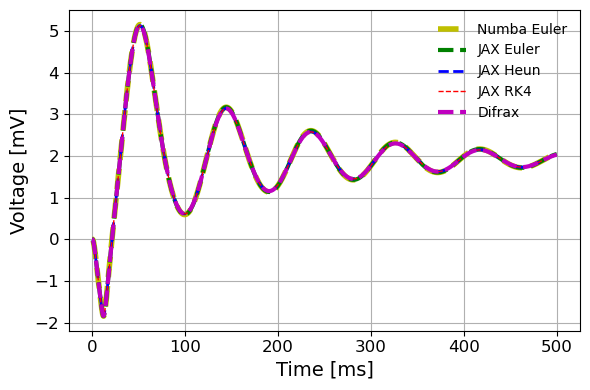

In [33]:
plt.figure(figsize=(6,4))
plt.plot(ts, xpy_numba,'--', color='y', lw=4, label='Numba Euler');
plt.plot(ts, xs_euler[:,8],'--', color='g', lw=3, label='JAX Euler');
plt.plot(ts, xs_heun[:,8],'--', color='b', lw=2, label='JAX Heun');
plt.plot(ts, xs_rk4[:,8],'--', color='r', lw=1, label='JAX RK4');
plt.plot(ts, xs_diffrax[:,8],'--', color='m', lw=3, label='Difrax');
plt.legend(fontsize=10, frameon=False, loc='upper right')
plt.ylabel('Voltage [mV]', fontsize=14); 
plt.xlabel('Time [ms]', fontsize=14); 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.tight_layout();
plt.savefig(os.path.join((output_dir),"Simulators.png"), dpi=300)
plt.show()

In [34]:
#See the dependency at last cell!
print(f"Numpy version: {np.__version__}")
print(f"JAX version: {jax.__version__}")
print(f"Diffrax version: {diffrax.__version__}")

Numpy version: 1.24.3
JAX version: 0.4.23
Diffrax version: 0.5.0


In [35]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Apr 19 2024

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.20.0

jax       : 0.4.23
pathlib   : 1.0.1
numpy     : 1.24.3
numba     : 0.59.0
diffrax   : 0.5.0
sys       : 3.11.7 (main, Dec 15 2023, 12:09:04) [Clang 14.0.6 ]
matplotlib: 3.8.0

Watermark: 2.4.3

